# Import Libraries for Analyzing Sequences


In [1]:
import pysam
import Bio
from Bio import SeqIO
from Bio.SeqUtils import GC
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import pandas as pd

# Read the Records for Chr 1 and 2 and Both Plasmids

In [2]:
def read_reference_records(filename):
    records = []
    with open(filename, "r") as reference_file:
        for record in SeqIO.parse(reference_file, "fasta"):
            records.append(record)
    return records
            
records = read_reference_records("ref1.fna")

# Compute GC Content of Regions of Interest

In [4]:
print(GC(records[0].seq[604711:607869]))
print(GC(records[0].seq[742894:743914]))
print(GC(records[0].seq[746902:747998]))
print(GC(records[0].seq[2662091:2662410]))
print(GC(records[0].seq[27933:28161]))

44.96516782773907
40.294117647058826
47.71897810218978
50.78369905956113
35.526315789473685


# Read the Alignment Positions from the Parsed SAM File

In [5]:
def read_sam_hits(filename):
    hits = []
    with open(filename, "r") as sam_parsed:
        for line in sam_parsed:
            tokens = line.split()
            hits.append((tokens[0], int(tokens[1])-1))
    return hits

sam_hits = read_sam_hits("sam_parsed_final.txt")
        

In [6]:
sam_hits[0:10]

[('NZ_CP009617.1', 904151),
 ('NZ_CP009617.1', 904065),
 ('NZ_CP009617.1', 1257417),
 ('NZ_CP009617.1', 1256912),
 ('NZ_CP009617.1', 827685),
 ('NZ_CP009617.1', 827668),
 ('NZ_CP009617.1', 129644),
 ('NZ_CP009617.1', 129476),
 ('NZ_CP009618.1', 531766),
 ('NZ_CP009618.1', 531367)]

In [7]:
sam_hits.sort(key=lambda tup: tup[1])
sam_hits[0:10]

[('NZ_CP009618.1', 0),
 ('NZ_CP009617.1', 0),
 ('NZ_CP009617.1', 0),
 ('NZ_CP009617.1', 0),
 ('NZ_CP009618.1', 0),
 ('NZ_CP009618.1', 0),
 ('NZ_CP009617.1', 0),
 ('NZ_CP009617.1', 0),
 ('NZ_CP009618.1', 0),
 ('NZ_CP009617.1', 0)]

# Compute the GC Content of the Sliding Windows

In [8]:
def get_sliding_window_metrics(records):
    results = []
    for record in records:
        window_start = 0
        str_seq = str(record.seq)
        str_seq_len = len(str_seq)
        while window_start < str_seq_len:
            gc_content = GC(str_seq[window_start:min(window_start+100, str_seq_len)])
            results.append([record.id, (window_start, window_start + 99), gc_content])
            window_start += 100
    return results

results = get_sliding_window_metrics(records)
        


In [9]:
results

[['NZ_CP009617.1', (0, 99), 39.0],
 ['NZ_CP009617.1', (100, 199), 35.0],
 ['NZ_CP009617.1', (200, 299), 30.0],
 ['NZ_CP009617.1', (300, 399), 36.0],
 ['NZ_CP009617.1', (400, 499), 43.0],
 ['NZ_CP009617.1', (500, 599), 51.0],
 ['NZ_CP009617.1', (600, 699), 48.0],
 ['NZ_CP009617.1', (700, 799), 47.0],
 ['NZ_CP009617.1', (800, 899), 47.0],
 ['NZ_CP009617.1', (900, 999), 53.0],
 ['NZ_CP009617.1', (1000, 1099), 47.0],
 ['NZ_CP009617.1', (1100, 1199), 48.0],
 ['NZ_CP009617.1', (1200, 1299), 50.0],
 ['NZ_CP009617.1', (1300, 1399), 48.0],
 ['NZ_CP009617.1', (1400, 1499), 41.0],
 ['NZ_CP009617.1', (1500, 1599), 42.0],
 ['NZ_CP009617.1', (1600, 1699), 49.0],
 ['NZ_CP009617.1', (1700, 1799), 55.0],
 ['NZ_CP009617.1', (1800, 1899), 49.0],
 ['NZ_CP009617.1', (1900, 1999), 47.0],
 ['NZ_CP009617.1', (2000, 2099), 53.0],
 ['NZ_CP009617.1', (2100, 2199), 46.0],
 ['NZ_CP009617.1', (2200, 2299), 48.0],
 ['NZ_CP009617.1', (2300, 2399), 46.0],
 ['NZ_CP009617.1', (2400, 2499), 42.0],
 ['NZ_CP009617.1', (250

In [10]:
def get_hit_counts(sam_hits):
    hit_count_dict = {}
    for (hid, pos) in sam_hits:
        if not (hid, pos) in hit_count_dict.keys():
            hit_count_dict[(hid, pos)] = 1
        else:
            hit_count_dict[(hid, pos)] += 1
    return hit_count_dict

hit_count_dict = get_hit_counts(sam_hits)

In [11]:
list(hit_count_dict.items())[0:20]

[(('NZ_CP009618.1', 0), 25),
 (('NZ_CP009617.1', 0), 38),
 (('NZ_CP009618.1', 1), 25),
 (('NZ_CP009617.1', 1), 13),
 (('NZ_CP009618.1', 2), 11),
 (('NZ_CP009617.1', 2), 2),
 (('NZ_CP009617.1', 3), 9),
 (('NZ_CP009618.1', 3), 8),
 (('NZ_CP009618.1', 4), 6),
 (('NZ_CP009617.1', 4), 9),
 (('NZ_CP009617.1', 5), 12),
 (('NZ_CP009618.1', 5), 2),
 (('NZ_CP009618.1', 6), 6),
 (('NZ_CP009617.1', 6), 4),
 (('NZ_CP009618.1', 7), 2),
 (('NZ_CP009617.1', 7), 3),
 (('NZ_CP009617.1', 9), 4),
 (('NZ_CP009618.1', 9), 2),
 (('NZ_CP009618.1', 10), 3),
 (('NZ_CP009617.1', 10), 2)]

In [12]:
def hit_counts_by_record(hit_count_dict):
    # records 19 and 20 represent the plasmids, which didn't have much coverage
    record_ids = ['NZ_CP009617.1', 'NZ_CP009618.1', 'NZ_CP009619.1', 'NZ_CP009620.1']
    record_counts = []
    for rid in record_ids:
        total = sum([count for ((faid, _), count) in hit_count_dict.items() if faid == rid])
        record_counts.append(total)
        
    return record_counts
print(hit_counts_by_record(hit_count_dict))

[2466549, 1265276, 0, 2613]


# Combine the Read Counts and Window Metrics into Final Results

In [13]:
def get_full_results(sliding_windows, hit_count_dict):
    results = []
    for window in sliding_windows:
        count = 0
        for i in range(window[1][0], window[1][1]+1):
            try:
                count += hit_count_dict[(window[0], i)]
            except Exception:
                None
        results.append(window + [count])
    return results

chrm_ids = ['NZ_CP009617.1', 'NZ_CP009618.1']
filtered_windows = [result for result in results if result[0] in chrm_ids]
full_results = get_full_results(filtered_windows, hit_count_dict)

In [14]:
full_results

[['NZ_CP009617.1', (0, 99), 39.0, 193],
 ['NZ_CP009617.1', (100, 199), 35.0, 119],
 ['NZ_CP009617.1', (200, 299), 30.0, 124],
 ['NZ_CP009617.1', (300, 399), 36.0, 99],
 ['NZ_CP009617.1', (400, 499), 43.0, 89],
 ['NZ_CP009617.1', (500, 599), 51.0, 92],
 ['NZ_CP009617.1', (600, 699), 48.0, 94],
 ['NZ_CP009617.1', (700, 799), 47.0, 78],
 ['NZ_CP009617.1', (800, 899), 47.0, 60],
 ['NZ_CP009617.1', (900, 999), 53.0, 66],
 ['NZ_CP009617.1', (1000, 1099), 47.0, 57],
 ['NZ_CP009617.1', (1100, 1199), 48.0, 78],
 ['NZ_CP009617.1', (1200, 1299), 50.0, 76],
 ['NZ_CP009617.1', (1300, 1399), 48.0, 69],
 ['NZ_CP009617.1', (1400, 1499), 41.0, 66],
 ['NZ_CP009617.1', (1500, 1599), 42.0, 60],
 ['NZ_CP009617.1', (1600, 1699), 49.0, 71],
 ['NZ_CP009617.1', (1700, 1799), 55.0, 68],
 ['NZ_CP009617.1', (1800, 1899), 49.0, 63],
 ['NZ_CP009617.1', (1900, 1999), 47.0, 73],
 ['NZ_CP009617.1', (2000, 2099), 53.0, 75],
 ['NZ_CP009617.1', (2100, 2199), 46.0, 91],
 ['NZ_CP009617.1', (2200, 2299), 48.0, 75],
 ['NZ_CP

In [15]:
df = pd.DataFrame(full_results, columns=["ID", "Window", "GC_Content", "Hits"])


In [49]:
df["Hits"].mean()

69.66342514521267

In [50]:
set(list(df["ID"]))

{'NZ_CP009617.1', 'NZ_CP009618.1'}

In [51]:
df.describe()

,GC_Content,Hits
count,53370.000000,53370.000000
mean,45.526044,69.663425
std,5.780657,28.094572
min,12.000000,0.000000
25%,42.000000,62.000000
50%,46.000000,73.000000
75%,49.000000,84.000000
max,74.000000,719.000000


In [17]:
df[df["GC_Content"] > 60].head(50)

,ID,Window,GC_Content,Hits
544,NZ_CP009617.1,"(54400, 54499)",61.0,81
1185,NZ_CP009617.1,"(118500, 118599)",61.0,70
1771,NZ_CP009617.1,"(177100, 177199)",62.0,53
1814,NZ_CP009617.1,"(181400, 181499)",63.0,70
2499,NZ_CP009617.1,"(249900, 249999)",64.0,77
6198,NZ_CP009617.1,"(619800, 619899)",61.0,57
6594,NZ_CP009617.1,"(659400, 659499)",63.0,58
7943,NZ_CP009617.1,"(794300, 794399)",65.0,57
8274,NZ_CP009617.1,"(827400, 827499)",61.0,69
8292,NZ_CP009617.1,"(829200, 829299)",65.0,93


In [18]:
df[df["GC_Content"] <= 45].head(100)

,ID,Window,GC_Content,Hits
0,NZ_CP009617.1,"(0, 99)",39.0,193
1,NZ_CP009617.1,"(100, 199)",35.0,119
2,NZ_CP009617.1,"(200, 299)",30.0,124
3,NZ_CP009617.1,"(300, 399)",36.0,99
4,NZ_CP009617.1,"(400, 499)",43.0,89
...,...,...,...,...
258,NZ_CP009617.1,"(25800, 25899)",33.0,107
263,NZ_CP009617.1,"(26300, 26399)",44.0,6
276,NZ_CP009617.1,"(27600, 27699)",44.0,110
279,NZ_CP009617.1,"(27900, 27999)",33.0,339


In [19]:
df.head(10)

,ID,Window,GC_Content,Hits
0,NZ_CP009617.1,"(0, 99)",39.0,193
1,NZ_CP009617.1,"(100, 199)",35.0,119
2,NZ_CP009617.1,"(200, 299)",30.0,124
3,NZ_CP009617.1,"(300, 399)",36.0,99
4,NZ_CP009617.1,"(400, 499)",43.0,89
5,NZ_CP009617.1,"(500, 599)",51.0,92
6,NZ_CP009617.1,"(600, 699)",48.0,94
7,NZ_CP009617.1,"(700, 799)",47.0,78
8,NZ_CP009617.1,"(800, 899)",47.0,60
9,NZ_CP009617.1,"(900, 999)",53.0,66


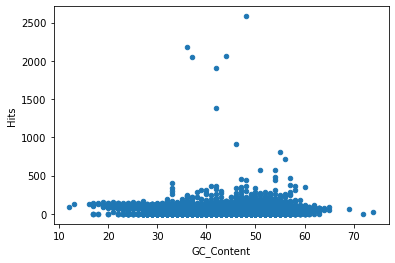

In [20]:
import matplotlib
df.plot.scatter("GC_Content", "Hits")

In [21]:
df = df[df["Hits"] <= 800]

In [43]:
high_gc = df[df["GC_Content"] >= 55.0]
low_gc = df[df["GC_Content"] <= 40.0]
low_gc.head(10)

,ID,Window,GC_Content,Hits
0,NZ_CP009617.1,"(0, 99)",39.0,193
1,NZ_CP009617.1,"(100, 199)",35.0,119
2,NZ_CP009617.1,"(200, 299)",30.0,124
3,NZ_CP009617.1,"(300, 399)",36.0,99
26,NZ_CP009617.1,"(2600, 2699)",36.0,83
33,NZ_CP009617.1,"(3300, 3399)",40.0,85
35,NZ_CP009617.1,"(3500, 3599)",40.0,85
46,NZ_CP009617.1,"(4600, 4699)",36.0,78
47,NZ_CP009617.1,"(4700, 4799)",35.0,78
51,NZ_CP009617.1,"(5100, 5199)",40.0,66


In [44]:
high_gc.head(10)

,ID,Window,GC_Content,Hits
17,NZ_CP009617.1,"(1700, 1799)",55.0,68
116,NZ_CP009617.1,"(11600, 11699)",57.0,90
121,NZ_CP009617.1,"(12100, 12199)",55.0,72
151,NZ_CP009617.1,"(15100, 15199)",55.0,80
181,NZ_CP009617.1,"(18100, 18199)",55.0,81
194,NZ_CP009617.1,"(19400, 19499)",55.0,81
200,NZ_CP009617.1,"(20000, 20099)",57.0,80
204,NZ_CP009617.1,"(20400, 20499)",56.0,50
208,NZ_CP009617.1,"(20800, 20899)",57.0,85
240,NZ_CP009617.1,"(24000, 24099)",56.0,69


In [45]:
len(low_gc)

9044

In [46]:
mean_high_hits = sum(list(high_gc["Hits"])) / len(high_gc)
mean_low_hits = sum(list(low_gc["Hits"])) / len(low_gc)

# Mean Number of Read Alignments for High GC vs. Low GC Windows

In [47]:
print(mean_high_hits)
print(mean_low_hits)

67.1867881548975
70.31932773109244


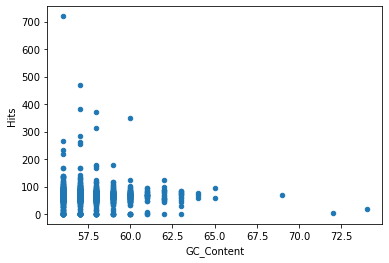

In [38]:
high_gc.plot.scatter("GC_Content", "Hits")

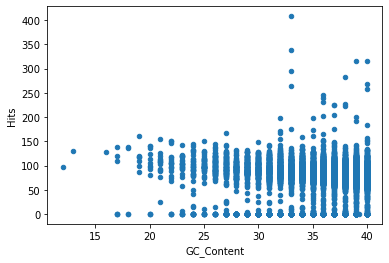

In [39]:
low_gc.plot.scatter("GC_Content", "Hits")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14be4bb90>]],
      dtype=object)

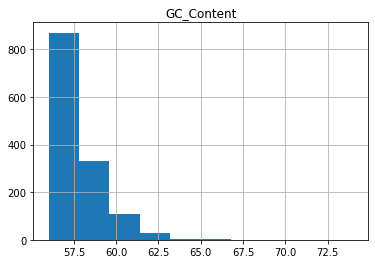

In [40]:
high_gc.hist("GC_Content")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14c200050>]],
      dtype=object)

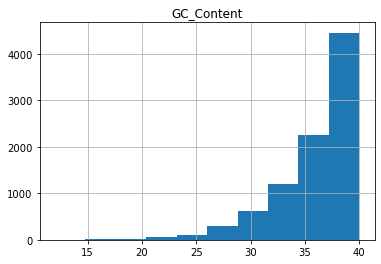

In [41]:
low_gc.hist("GC_Content")

In [48]:
from scipy.stats import ttest_ind
import numpy as np

ttest_ind(list(high_gc["Hits"]), list(low_gc["Hits"]), equal_var=False)

Ttest_indResult(statistic=-3.816242646713909, pvalue=0.00013773829487366665)

In [34]:
[result for result in full_results if result[0] == "NZ_CP009617.1"][0:20]

[['NZ_CP009617.1', (0, 99), 39.0, 193],
 ['NZ_CP009617.1', (100, 199), 35.0, 119],
 ['NZ_CP009617.1', (200, 299), 30.0, 124],
 ['NZ_CP009617.1', (300, 399), 36.0, 99],
 ['NZ_CP009617.1', (400, 499), 43.0, 89],
 ['NZ_CP009617.1', (500, 599), 51.0, 92],
 ['NZ_CP009617.1', (600, 699), 48.0, 94],
 ['NZ_CP009617.1', (700, 799), 47.0, 78],
 ['NZ_CP009617.1', (800, 899), 47.0, 60],
 ['NZ_CP009617.1', (900, 999), 53.0, 66],
 ['NZ_CP009617.1', (1000, 1099), 47.0, 57],
 ['NZ_CP009617.1', (1100, 1199), 48.0, 78],
 ['NZ_CP009617.1', (1200, 1299), 50.0, 76],
 ['NZ_CP009617.1', (1300, 1399), 48.0, 69],
 ['NZ_CP009617.1', (1400, 1499), 41.0, 66],
 ['NZ_CP009617.1', (1500, 1599), 42.0, 60],
 ['NZ_CP009617.1', (1600, 1699), 49.0, 71],
 ['NZ_CP009617.1', (1700, 1799), 55.0, 68],
 ['NZ_CP009617.1', (1800, 1899), 49.0, 63],
 ['NZ_CP009617.1', (1900, 1999), 47.0, 73]]

In [35]:
def samfile_stats(samfile):
    samfile = pysam.AlignmentFile(samfile, "r")
    iter = samfile.fetch()
    total = 0
    non_neg_pos = 0
    ref_regions = []
    no_hits = []
    pos = []
    for x in iter:
        total += 1
        if x.reference_start > -1:
            ref_regions.append(x.reference_id)
            pos.append(x.reference_start)
            non_neg_pos += 1
        else:
            no_hits.append(x.reference_id)
    
    print("ALIGNMENT RATE: ", non_neg_pos / total)
    print("REGIONS: ", set(ref_regions))
    print("NO HIT REGIONS: ", set(no_hits))
    
    return pd.DataFrame({"REGIONS":  ref_regions, "POSITION": pos})

In [36]:
# Alignment results from seed length of 19
df = samfile_stats("bowtie_align_vs_L15.sam")

ALIGNMENT RATE:  0.7911071680435274
REGIONS:  {0, 1, 2}
NO HIT REGIONS:  {-1}
